# Creating Feature Views and Training Dataset
---

## 🧑🏻‍🏫 Feature Views
`Feature Views` stands between **Feature Groups** and **Training Dataset**. Сombining **Feature Groups** we can create **Feature Views** which store a metadata of our data. Having **Feature Views** we can create **Training Dataset**.

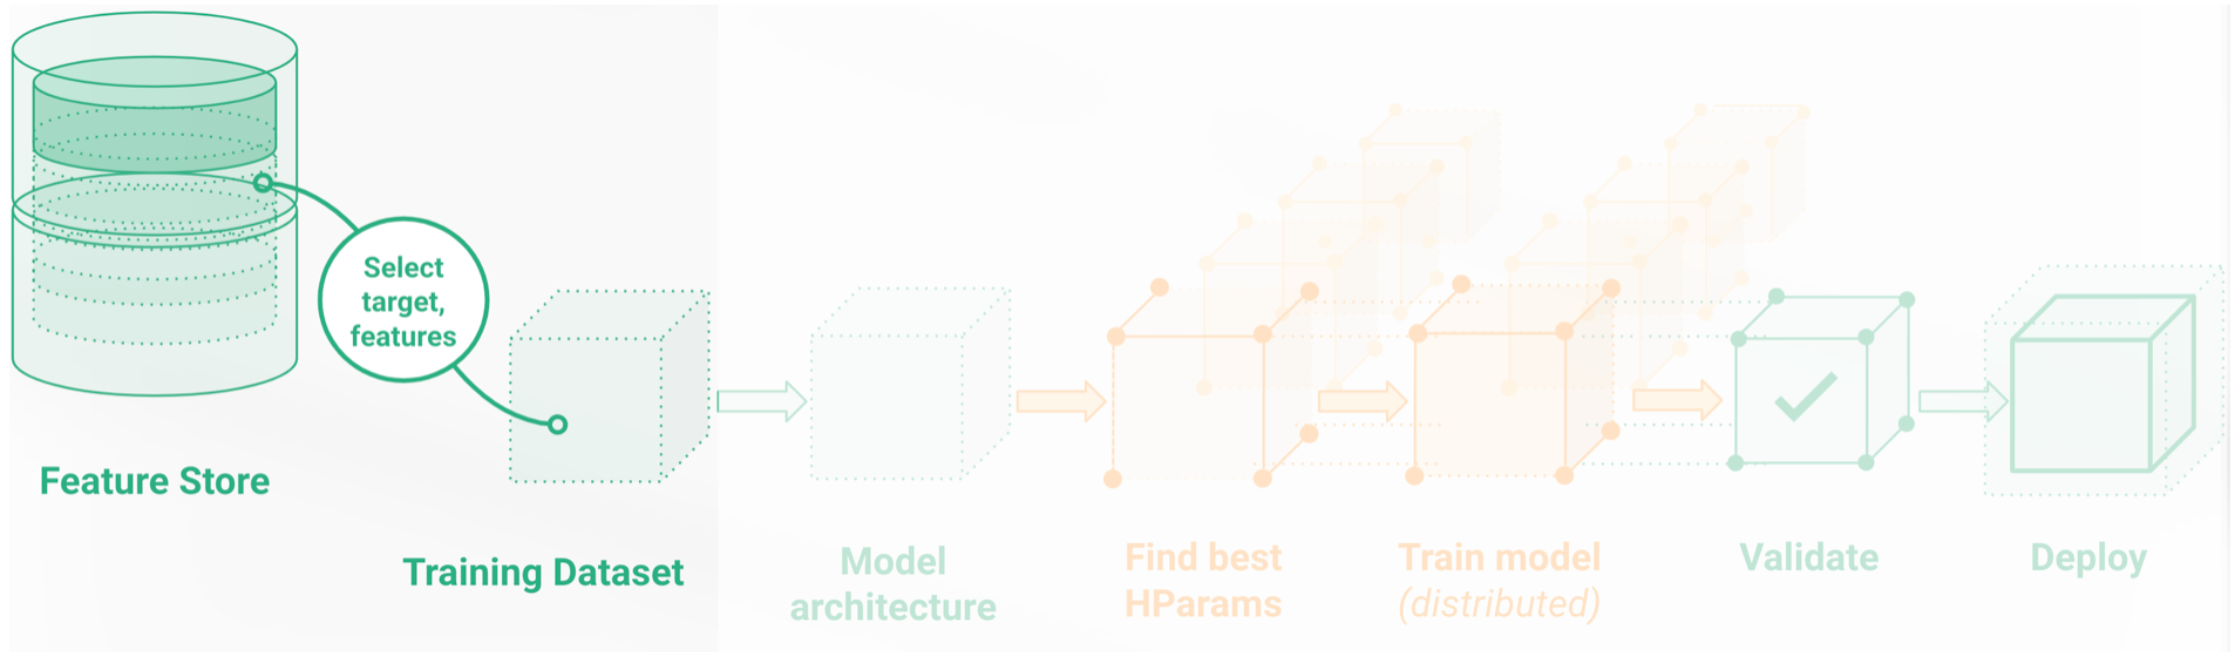
## 🧑🏻‍🏫 Training Dataset
The `training dataset` abstraction in Hopsworks Feature Store allows users to group a set of features (potentially from multiple different feature groups) with labels for training a model to do a particular prediction task. The `training dataset` is a versioned and managed dataset and is stored in HopsFS as **tfrecords**, **parquet**, **csv**, or **tsv** files.

---

# 🔮 Connecting to Feature Store and Retrieving Feature Groups

In [1]:
import hsfs

# Create a connection
connection = hsfs.connection()

# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


> In order to retrieve necessary Feature Group we can use `FeatureStore.get_feature_group()` method.

In [2]:
transactions_fg = fs.get_feature_group(
    name = "transactions_fg",
    version = 1
)

In [3]:
alert_transactions_fg = fs.get_feature_group(
    name = "alert_transactions_fg",
    version = 1
)

In [4]:
party_fg = fs.get_feature_group(
    name = "party_fg",
    version = 1
)

---

# 🕵🏻‍♂️ Feature Groups Investigation
We can use `FeatureGroup.show()` method to select top n rows. 

Also we use method `FeatureGroup.read()` in order **to aggregate queries**, which are the output of next methods:

- `FeatureGroup.get_feature()` to get specific feature from our Feature Group.

- `FeatureGroup.select()` to get a few features from our Feature Group.

- `FeatureGroup.select_all()` to get all features from our Feature Group.

- `FeatureGroup.select_except()` to get all features except a few from our Feature Group.

- `FeatureGroup.filter()` in order to apply specific filter to the feature group.



In [5]:
transactions_fg.select_all().show(5)

2022-05-28 18:02:22,968 INFO: USE `aml_demo_featurestore`
2022-05-28 18:02:23,846 INFO: SELECT `fg0`.`tran_timestamp` `tran_timestamp`, `fg0`.`source` `source`, `fg0`.`target` `target`, `fg0`.`tran_id` `tran_id`, `fg0`.`tx_type` `tx_type`, `fg0`.`base_amt` `base_amt`
FROM `aml_demo_featurestore`.`transactions_fg_1` `fg0`


,tran_timestamp,source,target,tran_id,tx_type,base_amt
0,1577836800000,e79c94d7,78bf8afb,125,4,964.06
1,1577836800000,c231c02a,a9495d80,1378,4,936.84
2,1577836800000,de99134b,a02a2693,936,4,213.89
3,1577836800000,a9495d80,adc76a5b,82,4,577.97
4,1577836800000,80fba3a8,8624e75d,64,4,316.99


In [6]:
transactions_fg.filter(transactions_fg.tran_id == 1378).show(5)

2022-05-28 18:07:09,915 INFO: USE `aml_demo_featurestore`
2022-05-28 18:07:10,771 INFO: SELECT `fg0`.`tran_timestamp` `tran_timestamp`, `fg0`.`source` `source`, `fg0`.`target` `target`, `fg0`.`tran_id` `tran_id`, `fg0`.`tx_type` `tx_type`, `fg0`.`base_amt` `base_amt`
FROM `aml_demo_featurestore`.`transactions_fg_1` `fg0`
WHERE `fg0`.`tran_id` = 1378


,tran_timestamp,source,target,tran_id,tx_type,base_amt
0,1577836800000,c231c02a,a9495d80,1378,4,936.84


---

# 🧑🏻‍🔬 Feature Views

In Hopsworks, you write features to feature groups (where the features are stored) and you read features from feature views. A feature view is a logical view over features, stored in feature groups, and a feature view typically contains the features used by a specific model. This way, feature views enable features, stored in different feature groups, to be reused across many different models.

---
# 💈Transformation functions

Transformation functions are a part of the feature types included in the feature view. The transformation functions are applied both (1) when features are read as DataFrames using the Offline API (to create training data or for batch scoring) and (2) when features are read as feature vectors using the Online API.  That is, a feature in a feature view is not only defined by its data type (int, string, etc) or its feature type (categorical, numerical, embedding), but also by any transformation function applied to it. The Feature View ensures that the transformation function is applied consistently when creating batches of data for training and individual rows (vectors) for online predictions. This solves the problem of training-serving skew, where transformation functions used to create training data and used for online feature vector processing may have different implementations, leading to difficult to diagnose model performance bugs. 

Hopsworks Feature Store comes with built-in transformation functions such as `min_max_scaler`, `standard_scaler`, `robust_scaler` and `label_encoder`. Users can also define custom transformation functions attach to feature in feature views. 

For more details about transformation functions refere to Hopsworks Feature Store documentation: https://docs.hopsworks.ai/feature-store-api


In [12]:
[t_func.name for t_func in fs.get_transformation_functions()]

['min_max_scaler', 'standard_scaler', 'label_encoder', 'robust_scaler']

To attach transformation function to features provide dictionary where key is feature name and value is online transformation function.

In [ ]:
# Load transformation functions.
label_encoder = fs.get_transformation_function(name = 'label_encoder')

#Map features to transformations.
mapping_transformers = {
    "is_sar": label_encoder
}

#### ⛳️ Graph Edge Feature View

In [7]:
edges_query = transactions_fg.select(["source","target","tran_id","tx_type","base_amt", "tran_timestamp"])

edges_query.read().head()

2022-05-28 18:09:47,793 INFO: USE `aml_demo_featurestore`
2022-05-28 18:09:48,645 INFO: SELECT `fg0`.`source` `source`, `fg0`.`target` `target`, `fg0`.`tran_id` `tran_id`, `fg0`.`tx_type` `tx_type`, `fg0`.`base_amt` `base_amt`, `fg0`.`tran_timestamp` `tran_timestamp`
FROM `aml_demo_featurestore`.`transactions_fg_1` `fg0`


,source,target,tran_id,tx_type,base_amt,tran_timestamp
0,e79c94d7,78bf8afb,125,4,964.06,1577836800000
1,c231c02a,a9495d80,1378,4,936.84,1577836800000
2,de99134b,a02a2693,936,4,213.89,1577836800000
3,a9495d80,adc76a5b,82,4,577.97,1577836800000
4,80fba3a8,8624e75d,64,4,316.99,1577836800000


In [8]:
edges_feature_view = fs.create_feature_view(
    name = 'edges_feature_view',
    version = 1,
    query = edges_query
)

#### ⛳️ Graph Node Feature View 

In [9]:
nodes_query = party_fg.select_all()

nodes_query.read().head()

2022-05-28 18:14:25,250 INFO: USE `aml_demo_featurestore`
2022-05-28 18:14:26,076 INFO: SELECT `fg0`.`id` `id`, `fg0`.`type` `type`
FROM `aml_demo_featurestore`.`party_fg_1` `fg0`


,id,type
0,90edf3b3,0
1,f3e394b3,0
2,f4f7c3ff,0
3,ba504e94,0
4,ff3b05c4,0


In [10]:
nodes_feature_view = fs.create_feature_view(
    name = 'nodes_feature_view',
    version = 1,
    query = nodes_query
)

---
# 🧬 Training Dataset

To create training dataset we use `FeatureView.create_training_dataset()` method.

Here are some importand things:

- It will inherit the name of FeatureView.

- The feature store currently supports the following data formats for
training datasets: **tfrecord, csv, tsv, parquet, avro, orc**.

- We can choose necessary format using **data_format** parameter.

- Also we can specify split ratio using **splits** parameter.

- **train_split** - specify which split will be used for training.

In [13]:
edges_feature_view.create_training_dataset(
    version = 1,
    description = 'edges training dataset',
    data_format = 'csv',
    splits = {'train': 80, 'validation': 20},
    train_split = "train",
    write_options = {'wait_for_job': True},
    coalesce = True
)

Training dataset job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/edges_feature_view_1_1_create_fv_td_28052022125459/executions


(1, <hsfs.core.job.Job at 0x7f05fa9edca0>)

In [14]:
nodes_feature_view.create_training_dataset(
    version = 1,
    description = 'node training dataset',
    data_format = 'csv',
    splits = {'train': 80, 'validation': 20},
    train_split = "train",
    write_options = {'wait_for_job': True},
    coalesce = True    
)

Training dataset job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/nodes_feature_view_1_1_create_fv_td_28052022131145/executions


(1, <hsfs.core.job.Job at 0x7f05f5ece4f0>)

Now our dataset has been splitted into two parts: **train(80% of original dataset)** and **validation(20% of original dataset)**.

> To get **training dataset** we can use `FeatureView.get_training_dataset()` method.

> To retrieve specific part of **training dataset** use `FeatureView.get_training_dataset_splits()` method.

---

# 🔮 Creating Training Datasets with Event Time filter

First of all lets import **datetime** from datetime library and set up a time format.

Then we can define start_time point and end_time point.

Finally we can create training dataset with data in specific time bourders. 


In [15]:
from datetime import datetime

In [23]:
date_format = '%Y-%m-%d %H:%M:%S'

start_time = int(float(datetime.strptime('2020-01-01 00:00:01',date_format).timestamp()) * 1000)
end_time = int(float(datetime.strptime('2020-12-31 23:59:59',date_format).timestamp()) * 1000)

In [21]:
pdf = transactions_fg.read()

2022-05-28 13:53:17,117 INFO: USE `aml_demo_featurestore`
2022-05-28 13:53:17,993 INFO: SELECT `fg0`.`tran_timestamp` `tran_timestamp`, `fg0`.`source` `source`, `fg0`.`target` `target`, `fg0`.`tran_id` `tran_id`, `fg0`.`tx_type` `tx_type`, `fg0`.`base_amt` `base_amt`
FROM `aml_demo_featurestore`.`transactions_fg_1` `fg0`


In [ ]:
pdf.head()

,tran_timestamp,source,target,tran_id,tx_type,base_amt
0,1577836800000,b6bb3d19,c8ba6fea,355,4,367.44
1,1577836800000,a6f8f78e,295e0390,332,4,294.23
2,1577836800000,75eb69c3,ecdb7796,1376,4,778.69
3,1577836800000,462246fd,a30b282a,1381,4,605.83
4,1577836800000,3aed1a5e,bf1da2a0,1058,4,233.24


In [26]:
td_version, td_job = edges_feature_view.create_training_dataset(
    description = 'transactions_2020',
    version = 2,
    data_format = 'csv',
    write_options = {'wait_for_job': True},
    coalesce = True, 
    start_time = start_time,
    end_time = end_time
)

Training dataset job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/edges_feature_view_1_2_create_fv_td_28052022140011/executions


In [28]:
start_time = int(float(datetime.strptime('2021-01-01 00:00:01',date_format).timestamp()) * 1000)
end_time = int(float(datetime.strptime('2021-12-31 23:59:59',date_format).timestamp()) * 1000)
td_version, td_job = edges_feature_view.create_training_dataset(
    description = 'transactions_2021',
    version = 3,
    data_format = 'csv',
    write_options = {'wait_for_job': True},
    coalesce = True, 
    start_time = start_time,
    end_time = end_time
)

Training dataset job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/edges_feature_view_1_3_create_fv_td_28052022140807/executions


### 🔬 Dataset Retrieval

To retrieve training dataset from Feature Store we can use `get_training_dataset_splits()` or `get_training_dataset()` methods. 

If version is not provided - new one will be created.
If version is provided and version exists - retrieves trainining dataset and returns as dataframe.

In [3]:
td_version, df = edges_feature_view.get_training_dataset(
    {},
    version = td_version
)

df.head()

Connected. Call `.close()` to terminate connection gracefully.


,source,target,tran_id,tx_type,base_amt
0,6f4b3e09,28635253,658111,4,984.53
1,52b952e3,e5cd7b59,659011,4,853.26
2,b7d850c8,22f13fd8,658129,4,651.03
3,f80b5ac3,eb0bd07f,658589,4,286.96
4,9d2560fa,fd77a141,658775,4,604.60


---